The following modification is an attempt to move all text preocessing into layers which can be included with the model.

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load Packages

In [2]:
#import packages
import pandas as pd
import io
import os
from google.colab import files
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Input, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional


random_state = 5590

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import Data
The training data is imported and the necessary columns are converted to lists.

In [3]:
#import data
path_dir_data = 'gdrive/MyDrive/Colab/CausalityExtractionNLP/data'
file_training_data = 'training_data.xlsx'
path_training_data = os.path.join(path_dir_data, file_training_data)
dataset = pd.read_excel(path_training_data)

In [4]:
# -*- coding: utf-8 -*-
"""Entity_Extraction.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1MEpAYceQU4SAev6RSyfL5DJxQnk2ClZp
"""

#convert into lists
df = pd.DataFrame({'label':dataset.causal_relationship, 
                   'text':dataset.sentence, 
                   'node1':dataset.node_1, 
                   'node2':dataset.node_2})
df = df.dropna()
description_list = df['text'].tolist()
node1_list = df['node1'].tolist()
node2_list = df['node2'].tolist()

# Split Data into Training / Test Sets

In [46]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df,
                                     test_size=0.25, 
                                     random_state = random_state)

text_train = df_train['text'].tolist()
text_test = df_test['text'].tolist()

# Extract Training Text and Create Vectorization Layer

We perform this step here just to ensure we know the size of our vocabulary. We will need to length to define our target variable.

In [6]:
from keras.layers.experimental.preprocessing import TextVectorization
max_features = 1000
max_len = 70

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=max_len)

vectorize_layer.adapt(text_train)

vocab_len = len(vectorize_layer.get_vocabulary())

print(vocab_len)

1000


In [55]:
model_text = Sequential()
model_text.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model_text.add(vectorize_layer)
x_train_xfrm = model_text.predict(text_train)
x_test_xfrm = model_text.predict(text_test)

# Create Targte Variable
We need to define a target variable.

This is a several step process, and we need to do this for train and test sets, so it is best to create a function.
## Input Values / Functions

In [8]:
def sentenceGetter(sentence, labels):
   vocab = sentence.split(" ")
   sen_group =[]
   for i in range(len(vocab)):
     sen_group.append((vocab[i], labels[i]))
   return sen_group

#create tags
tags = []
tags.append(0)
tags.append(1)
tags.append(2)
n_tags = len(tags)


tag2idx = {t: i for i, t in enumerate(tags)}


## Target Variable Function

In [9]:
def create_target(df):
    description_list = df['text'].tolist()
    node1_list = df['node1'].tolist()
    node2_list = df['node2'].tolist()

    # Text Processing
    for i, n in enumerate(node2_list): 
        node2_list[i] = n.lower() \
                        .replace('.', '') \
                        .replace(',', '')

    for j, n in enumerate(node1_list): 
        node1_list[j] = n.lower() \
                        .replace('.', '') \
                        .replace(',', '')

    for k, n in enumerate(description_list): 
        description_list[k] = n.lower() \
                                .replace('.', '') \
                                .replace(',', '') \
                                .replace(':', '')
    
    # Generate Labels
    labels = []
    for i, sen in enumerate(description_list):
        words = sen.split(" ")
        labels1 = np.zeros(len(words))
        node1 = node1_list[i].split(" ")
        node2 = node2_list[i].split(" ")

        for n1 in node1: 
            hold = words.index(n1)
            labels1[hold] = 1

        for n2 in node2: 
            hold = words.index(n2)
            labels1[hold] = 2

        labels.append(labels1)

    # Append Sentences
    sentences = []

    for i, sentence in enumerate(description_list): 
        sen_group = sentenceGetter(sentence, labels[i])
        sentences.append(sen_group)

    # Keras Processing
    #process data
    y = [[tag2idx[w[1]] for w in s] for s in sentences]

    y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx[0])

    y = [to_categorical(i, num_classes=n_tags) for i in y]

    return(y)

### Execute Variable Creation

In [10]:
y_train = create_target(df_train)
y_te = create_target(df_test)

## Convert Y Test
This step essentially reverses the one-hot encoding of the target variable.

In [11]:
y_test = []
for y in y_te:
  y_hold = []
  for r in y:
    if r[0] == 1:
      y_hold.append(0)
    if r[1] ==1:
      y_hold.append(1)
    if r[2] == 1:
      y_hold.append(2)
  y_test.append(y_hold)

# Build Model

## Text Process External

In [60]:
embedding_dim = 64

x_train_xfrm = model_text.predict(text_train)
y_train_np = np.array(y_train_np)

#build LSTM
model = Sequential()
model.add(tf.keras.Input(shape=(max_len,)))
model.add(Embedding(input_dim = max_features + 1, 
                    output_dim = embedding_dim,
                    input_length = max_len))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=3, return_sequences=True, 
                             recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(n_tags, activation="softmax"))) 

model.compile(optimizer="rmsprop", loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

# history = model.fit(x_train_xfrm, y_train_np, batch_size=32, epochs=60, 
#                     validation_split=0.1, verbose=1)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 70, 64)            64064     
_________________________________________________________________
dropout_18 (Dropout)         (None, 70, 64)            0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 70, 6)             1632      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 70, 3)             21        
Total params: 65,717
Trainable params: 65,717
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
14/14 [==============================] - 7s 130ms/step - loss: 0.9924 - accuracy: 0.8824 - val_loss: 0.8295 - val_accuracy: 0.9051
Epoch 2/60
14/14 [==============================] - 1s 89ms/step - loss: 0.7855 - accuracy: 0.8959 - val_

KeyboardInterrupt: ignored

## Text Processing Embedded

In [73]:
text_train_tf = tf.data.Dataset.from_tensor_slices(text_train)
text_train_np = np.array(text_train)

In [75]:
embedding_dim = 64

#build LSTM
model = Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(Embedding(input_dim = max_features + 1, 
                    output_dim = embedding_dim,
                    input_length = max_len))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=3, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(n_tags, activation="softmax"))) # softmax output layer

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

history = model.fit(text_train_np, y_train_np, batch_size=32, epochs=60, validation_split=0.1, verbose=1)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 70)                0         
_________________________________________________________________
embedding_24 (Embedding)     (None, 70, 64)            64064     
_________________________________________________________________
dropout_24 (Dropout)         (None, 70, 64)            0         
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 70, 6)             1632      
_________________________________________________________________
time_distributed_24 (TimeDis (None, 70, 3)             21        
Total params: 65,717
Trainable params: 65,717
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
14/14 [==============================] - 7s 140ms/step - loss: 1.0415 - accuracy: 0.6299 - val_loss: 0.8

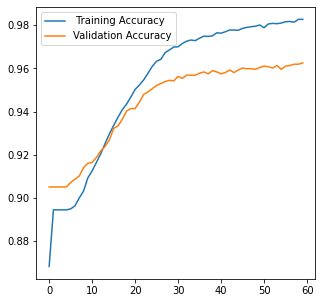

In [44]:
hist = pd.DataFrame(history.history)

#plot training and validation accuracy
f = plt.figure(figsize=(5,5))
plt.plot(hist["accuracy"], label =' Training Accuracy')
plt.plot(hist["val_accuracy"], label='Validation Accuracy')
plt.legend(loc="upper left")
plt.show()
f.savefig( "test.png")
# f.download("test.png")

In [56]:
#calculate test set accuracy
error = []
false0 = []
num1 = []
num2 = []
false1 = []
for i in range(len(x_test_xfrm)):
  p = model.predict(np.array([x_test_xfrm[i]]))
  p = np.argmax(p, axis=-1)
  ypred = p[0]
  yt = y_test[i]
  for j in range(len(ypred)):
    if yt[j] == 1:
      num1.append(1)
    if yt[j] == 2:
      num2.append(1)
    if ypred[j] == yt[j]:
      error.append(0)
    else:
      error.append(1)
      if yt[j] == 1:
        false0.append(True)
      else:
        false0.append(False)
      if yt[j] == 2:
        false1.append(True)
      else:
        false1.append(False)

#overall accuracy
print(1 - sum(error)/len(error))

#accuracy of node1 classification
print(1 - sum(false0)/sum(num1))

#accuracy of node2 classification
print(1 - sum(false1)/sum(num2))



0.958041329739443
0.8131313131313131
0.7150537634408602


# Save and Restore Model

## Save

In [76]:
# Export Model
folder_keras_model = 'entity_extraction_w_processing_keras'
path_keras_model = os.path.join(path_dir_data, folder_keras_model)

model.save(path_keras_model)

INFO:tensorflow:Assets written to: gdrive/MyDrive/Colab/CausalityExtractionNLP/data/entity_extraction_w_processing_keras/assets


# Restore

In [77]:
from tensorflow import keras
model = keras.models.load_model(path_keras_model)

In [85]:
vec = model.get_layer('text_vectorization')
vec.get_vocabulary()

['',
 '[UNK]',
 'hypo',
 'the',
 'and',
 'performance',
 'of',
 'to',
 'a',
 'positively',
 'is',
 'related',
 '1',
 'with',
 'will',
 '2',
 'that',
 'on',
 'be',
 'between',
 'in',
 'positive',
 'relationship',
 '3',
 'associated',
 'environmental',
 '4',
 'reputation',
 'higher',
 'firms',
 'market',
 'are',
 'organizational',
 'firm',
 'turnover',
 'management',
 'strategy',
 'employee',
 'practices',
 'effect',
 'more',
 'have',
 'greater',
 'csr',
 'than',
 'impact',
 '5',
 'for',
 'financial',
 'its',
 'systems',
 'level',
 'negatively',
 'customer',
 'satisfaction',
 'orientation',
 'ﬁrm',
 'not',
 'high',
 'has',
 'by',
 'ﬁrm’s',
 'as',
 'innovation',
 'human',
 'hrm',
 'an',
 '6',
 'there',
 'competitive',
 'quality',
 'ﬁnancial',
 'their',
 'resource',
 'negative',
 'hr',
 'product',
 'levels',
 'interaction',
 'business',
 'job',
 'hypothesis',
 'better',
 'was',
 'pay',
 'likely',
 'firm’s',
 'work',
 'support',
 'signiﬁcantly',
 'economic',
 'corporate',
 'commitment',
 'w